# Data Mining Project: Adult Dataset

## Setup

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC


warnings.filterwarnings('ignore')

# Part 1: Classification with Categorical Data

Preprocess the data to use only the categorical attributes and then build a Decision Tree and a Naïve Bayes classifier.

### Preprocess Data

In [16]:
train_path = 'adult/adult.data'
test_path = 'adult/adult.test'

def preprocess_categorical_only(train_path, test_path):
   
    # Define column names
    columns = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]

    # Read train and test data
    df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?")
    df_test = pd.read_csv(test_path, header=None, names=columns, na_values=" ?", skiprows=1)

    # --- Data Cleaning ---
    # Drop rows with any missing values
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)

    # Clean the income column in the test set (removes trailing period)
    df_test['income'] = df_test['income'].str.replace(r'\.', '', regex=True)

    # --- Feature Selection ---
    # Identify continuous columns to drop
    continuous_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
    df_train = df_train.drop(columns=continuous_cols)
    df_test = df_test.drop(columns=continuous_cols)

    # Separate features (X) and target (y)
    X_train_cat = df_train.drop(columns=['income'])
    y_train = df_train['income']
    X_test_cat = df_test.drop(columns=['income'])
    y_test = df_test['income']

    # --- Encoding ---
    # Apply one-hot encoding
    X_train = pd.get_dummies(X_train_cat)
    X_test = pd.get_dummies(X_test_cat)
    
    # Align columns between train and test sets to ensure they have the same features
    train_cols = X_train.columns
    test_cols = X_test.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test[c] = 0
    missing_in_train = set(test_cols) - set(train_cols)
    for c in missing_in_train:
        X_train[c] = 0
    X_test = X_test[train_cols] # Ensure order is the same

    # Encode the target variable (<=50K -> 0, >50K -> 1)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    print("Part 1 Preprocessing Complete.")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test

# Execute the function
X_train_cat, y_train_cat, X_test_cat, y_test_cat = preprocess_categorical_only('adult/adult.data', 'adult/adult.test')

Part 1 Preprocessing Complete.
Training data shape: (30162, 98)
Test data shape: (15060, 98)


### Decision Tree Classifier

Trains a Decision Tree classifier on the preprocessed categorical data and evaluates its performance on the test set.

In [ ]:
def run_decision_tree(X_train, y_train, X_test, y_test):

    print("\n--- Running Decision Tree Classifier ---")
    # Initialize and train the model
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = dt_classifier.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

    # Calculate and print TP and FP rates from the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    print(f"True Positive Rate (Recall) for '>50K': {tp_rate:.4f}")
    print(f"False Positive Rate for '>50K': {fp_rate:.4f}")

    return dt_classifier

# Execute the Decision Tree function
dt_classifier = run_decision_tree(X_train_cat, y_train_cat, X_test_cat, y_test_cat)


--- Running Decision Tree Classifier ---
Accuracy: 0.8120185922974767

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.86      0.89      0.88     11360
        >50K       0.63      0.56      0.59      3700

    accuracy                           0.81     15060
   macro avg       0.75      0.73      0.74     15060
weighted avg       0.81      0.81      0.81     15060

True Positive Rate (Recall) for '>50K': 0.5597
False Positive Rate for '>50K': 0.1058


Feature Importance for Decision Tree

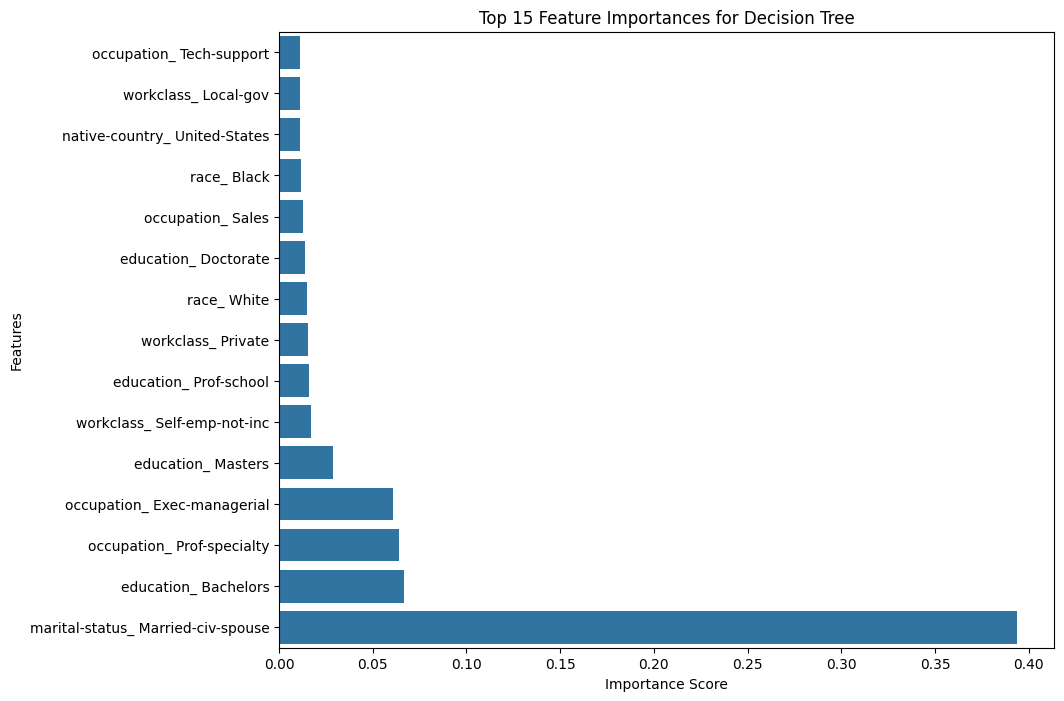

In [28]:
def plot_feature_importance(model, feature_names, top_n=15):
    
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Get the top N feature names and their importance scores
    top_indices = indices[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]

    # Create the plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_importances, y=top_features)
    plt.title(f'Top {top_n} Feature Importances for Decision Tree')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.gca().invert_yaxis() # Display the most important feature at the top
    plt.show()

plot_feature_importance(dt_classifier, X_train_cat.columns)    

### Naïve Bayes Classifier

Trains a Naïve Bayes classifier. Given that our data is now a sparse, count-based matrix from one-hot encoding.

In [ ]:
def run_naive_bayes(X_train, y_train, X_test, y_test):

    print("\n--- Running Naïve Bayes Classifier ---")
    # Initialize and train the model
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = nb_classifier.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))
    
    # Calculate and print TP and FP rates
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    print(f"True Positive Rate (Recall) for '>50K': {tp_rate:.4f}")
    print(f"False Positive Rate for '>50K': {fp_rate:.4f}")

    return y_pred

# Execute the Naive Bayes function
y_pred = run_naive_bayes(X_train_cat, y_train_cat, X_test_cat, y_test_cat)


--- Running Naïve Bayes Classifier ---
Accuracy: 0.7940239043824702

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86     11360
        >50K       0.56      0.74      0.64      3700

    accuracy                           0.79     15060
   macro avg       0.73      0.78      0.75     15060
weighted avg       0.82      0.79      0.80     15060

True Positive Rate (Recall) for '>50K': 0.7400
False Positive Rate for '>50K': 0.1884


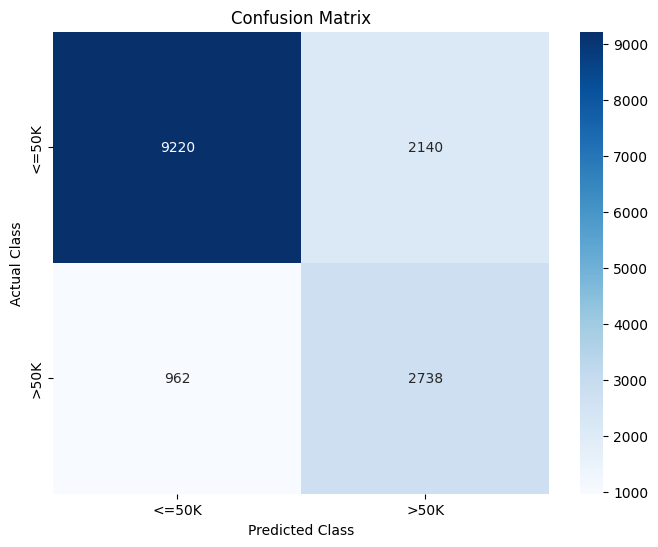

In [32]:
def plot_confusion_matrix(y_true, y_pred, class_names):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

plot_confusion_matrix(y_test_cat, y_pred, ['<=50K', '>50K'])

# Part 2: Clustering & Classification with Transformed Data

Numerical data will be binarized based on its mean, and categorical data will be one-hot encoded.

### Preprocess Data

Clean unknown values, binarizing numerical attributes values above the column's mean become `1`, and others become `0`. and One-hot encoding categorical attributes.

In [20]:
def preprocess_mixed_transformed(train_path, test_path):

    # Define column names
    columns = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]
    
    df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?")
    df_test = pd.read_csv(test_path, header=None, names=columns, na_values=" ?", skiprows=1)

    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)
    df_test['income'] = df_test['income'].str.replace(r'\.', '', regex=True)

    # Combine for consistent processing
    combined_df = pd.concat([df_train, df_test], axis=0)

    # --- Feature Transformation ---
    numerical_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
    categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

    # Binarize numerical columns
    for col in numerical_cols:
        mean_val = combined_df[col].mean()
        combined_df[col] = (combined_df[col] > mean_val).astype(int)

    # One-hot encode categorical columns
    combined_df = pd.get_dummies(combined_df, columns=categorical_cols)

    # Encode target variable
    combined_df['income'] = LabelEncoder().fit_transform(combined_df['income'])

    # Split back into train and test sets
    train_size = len(df_train)
    df_train_processed = combined_df.iloc[:train_size]
    df_test_processed = combined_df.iloc[train_size:]

    X_train = df_train_processed.drop(columns=['income'])
    y_train = df_train_processed['income']
    X_test = df_test_processed.drop(columns=['income'])
    y_test = df_test_processed['income']

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test

# Execute the function
X_train_mix, y_train_mix, X_test_mix, y_test_mix = preprocess_mixed_transformed('adult/adult.data', 'adult/adult.test')

Training data shape: (30162, 104)
Test data shape: (15060, 104)


### k-Means Clustering

Applie the k-Means algorithm to the transformed training data for `k` values of 3, 5, and 10, reporting the centroids for each.

In [21]:
def run_kmeans(X_train, k_values=[3, 5, 10]):

    print("\n--- Running k-Means Clustering ---")
    for k in k_values:
        print(f"\nRunning with k = {k}")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_train)
        print(f"Centroids for {k} clusters (showing first 5 dimensions for brevity):")
        # Centroids can be very large, so we print a snippet
        print(kmeans.cluster_centers_[:, :5])

# Execute the k-Means function
run_kmeans(X_train_mix)


--- Running k-Means Clustering ---

Running with k = 3
Centroids for 3 clusters (showing first 5 dimensions for brevity):
[[0.64366135 0.40619974 0.30443047 0.06755374 0.03772481]
 [0.60964564 0.42587001 0.37486096 0.12148419 0.06523121]
 [0.17490919 0.47350284 0.28900065 0.04461209 0.03241129]]

Running with k = 5
Centroids for 5 clusters (showing first 5 dimensions for brevity):
[[ 4.18361418e-01  4.30563626e-01  2.22254503e-02  3.74782103e-02
   2.62928530e-02]
 [ 6.44661431e-01  4.16472087e-01  1.00000000e+00  1.69178518e-01
   8.83039694e-02]
 [ 2.40459304e-01  4.85309017e-01  4.06957109e-02  3.93448159e-02
   2.97196893e-02]
 [ 5.88962529e-01  4.31302575e-01 -2.44249065e-15  9.25312261e-02
   5.13637522e-02]
 [ 4.14878100e-01  4.24671807e-01  9.99791623e-01  9.50197958e-02
   5.23025630e-02]]

Running with k = 10
Centroids for 10 clusters (showing first 5 dimensions for brevity):
[[6.63719422e-01 3.94046566e-01 1.85676393e-02 5.30503979e-02
  3.15355143e-02]
 [7.23470662e-01 3.6


--- Plotting k-Means Elbow Curve ---


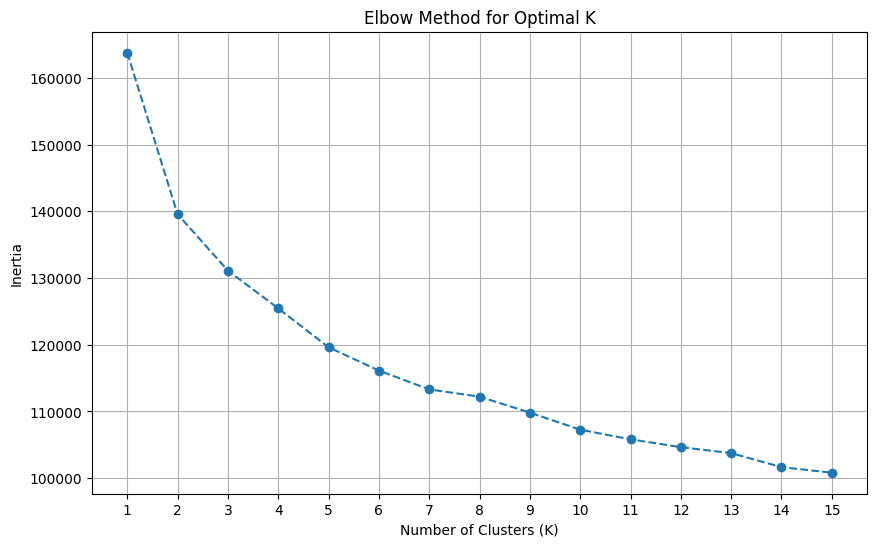

In [29]:
def plot_kmeans_elbow_curve(X_data, max_k=15):
    print("\n--- Plotting k-Means Elbow Curve ---")
    inertias = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

# Execute the elbow curve function
plot_kmeans_elbow_curve(X_train_mix)

### k-Nearest Neighbors (kNN)

Train kNN classifier and uses it to predict the class for the last 10 records of the test data, testing `k` values of 3, 5, and 10.

In [22]:
def run_knn(X_train, y_train, X_test, y_test, k_values=[3, 5, 10]):

    print("\n--- Running k-Nearest Neighbors (kNN) ---")
    # Use the last 10 records for prediction
    X_test_subset = X_test.tail(10)
    y_test_subset = y_test.tail(10)
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test_subset)
        accuracy = accuracy_score(y_test_subset, y_pred)
        print(f"Prediction accuracy for k = {k} on the last 10 records: {accuracy:.2f}")

# Execute the kNN function
run_knn(X_train_mix, y_train_mix, X_test_mix, y_test_mix)


--- Running k-Nearest Neighbors (kNN) ---
Prediction accuracy for k = 3 on the last 10 records: 0.70
Prediction accuracy for k = 5 on the last 10 records: 0.80
Prediction accuracy for k = 10 on the last 10 records: 0.80


### Support Vector Machine (SVM)

Build SVM classifier on the transformed data and reports its accuracy on the full test set.

In [33]:
def run_svm(X_train, y_train, X_test, y_test):

    print("\n--- Running Support Vector Machine (SVM) ---")
    svm_classifier = SVC(kernel='linear', random_state=42) # Using a linear kernel for efficiency
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM prediction accuracy on the test data: {accuracy:.4f}")
    return y_pred
# Execute the SVM function
y_pred = run_svm(X_train_mix, y_train_mix, X_test_mix, y_test_mix)


--- Running Support Vector Machine (SVM) ---
SVM prediction accuracy on the test data: 0.8435



--- Generating SVM Decision Boundary Visualization ---


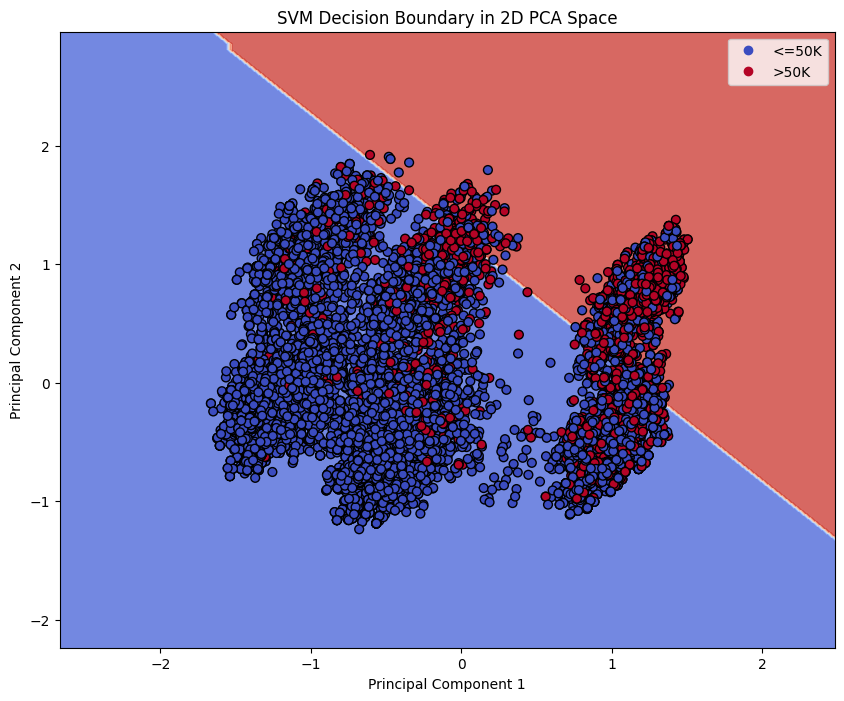

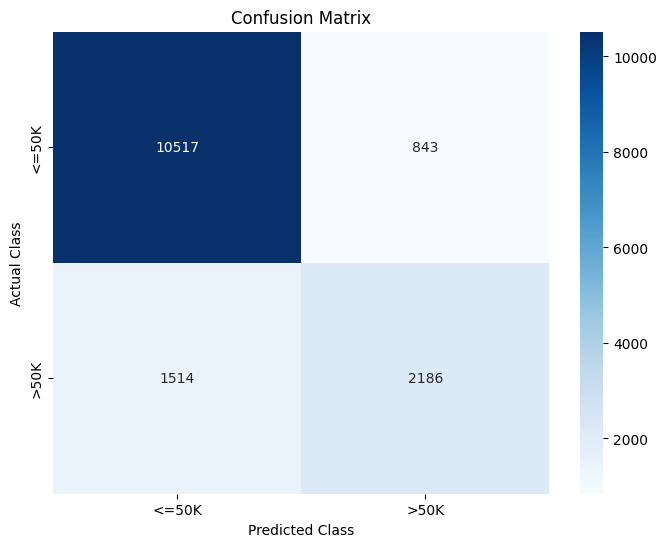

In [38]:
def plot_svm_decision_boundary(X_train, y_train, X_test, y_test):

    print("\n--- Generating SVM Decision Boundary Visualization ---")
    
    # --- 1. Reduce data to 2 dimensions with PCA ---
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # --- 2. Train a new SVM on the 2D PCA data ---
    # We train a new model here specifically for the 2D visualization
    svm_2d = SVC(kernel='linear', random_state=42)
    svm_2d.fit(X_train_pca, y_train)

    # --- 3. Create a mesh grid for plotting ---
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    h = 0.05  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # --- 4. Make predictions on the grid ---
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # --- 5. Plot the decision boundary and data points ---
    plt.figure(figsize=(10, 8))
    # Plot the colored regions
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot the test data points to see how the model generalizes
    scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                          cmap=plt.cm.coolwarm, edgecolors='k', s=40)
    
    plt.title('SVM Decision Boundary in 2D PCA Space')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=['<=50K', '>50K'])
    plt.show()

plot_svm_decision_boundary(X_train_mix, y_train_mix, X_test_mix, y_test_mix)

def plot_confusion_matrix(y_true, y_pred, class_names):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

plot_confusion_matrix(y_test_cat, y_pred, ['<=50K', '>50K'])    

### Neural Network

Build Neural Network (Multi-layer Perceptron) classifier and reports its accuracy on the test set.

In [24]:
def run_neural_network(X_train, y_train, X_test, y_test):

    print("\n--- Running Neural Network ---")
    # A simple NN with two hidden layers
    nn_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
    nn_classifier.fit(X_train, y_train)
    y_pred = nn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Neural Network prediction accuracy on the test data: {accuracy:.4f}")

# Execute the Neural Network function
run_neural_network(X_train_mix, y_train_mix, X_test_mix, y_test_mix)


--- Running Neural Network ---
Neural Network prediction accuracy on the test data: 0.8116
